<div style="background-color: #e7f3fe; border: 1px solid #2196F3; padding: 30px; border-radius: 5px; box-shadow: 2px 2px 5px grey; text-align: center;">
    <b>Projet de CVAE</b>
</div>

<div style="border: 2px solid #4CAF50; padding: 15px; border-radius: 10px; background-color: #F9F9F9;">

##  **CVAE : Extension Conditionnelle du VAE**

Le **Conditional Variational Autoencoder (CVAE)** est une extension du VAE qui permet de conditionner le processus de génération sur une variable d'entrée spécifique, comme un label ou une autre information contextuelle. Cela permet au modèle de générer des sorties qui sont non seulement plausibles mais également cohérentes avec l'information conditionnelle.

---

### **Conditionnement**
Contrairement au VAE, le CVAE conditionne la génération des échantillons sur des variables supplémentaires $y$, comme un label de classe.

**Objectif** : Maximiser la probabilité conditionnelle $p(x|y)$, où $y$ est la condition (par exemple un label).  
**Fonction de perte du CVAE** :  
$$
\mathcal{L}_{CVAE}(x, y) = \mathbb{E}_{q(z|x,y)}[\log p(x|z,y)] - D_{KL}(q(z|x,y) || p(z|y))
$$

---

### **Processus du CVAE**

- **Encodeur Conditionnel** :  
  $$q(z|x, y)$$  
  L'encodeur prend en compte à la fois l'entrée $x$ et la condition $y$ pour générer les paramètres de la distribution latente $z$.
  
- **Décodeur Conditionnel** :  
  $$p(x|z, y)$$  
  Le décodeur génère des échantillons à partir du vecteur latent $z$, tout en étant conditionné par $y$.

Le modèle vise à :  
✔️ Minimiser la divergence entre la distribution approximée $q(z|x, y)$ et la distribution prioritaire $p(z|y)$.  
✔️ Maximiser la probabilité de reconstruction conditionnelle $p(x|z, y)$.

---

###  **Fonction de Perte et Optimisation**

La fonction de perte du CVAE est similaire à celle du VAE, mais modifiée pour intégrer la variable conditionnelle $y$.  
Elle se compose de deux termes principaux :  
1. **Erreur de reconstruction** :  
   Mesure l'erreur entre la sortie générée et l'entrée conditionnée sur $y$.  
2. **Divergence KL** :  
   Réduit l'écart entre $q(z|x, y)$ et $p(z|y)$, forçant ainsi une régularisation de l'espace latent.

---

</div>



<div style="background-color: #f7f7f7; border: 1px solid #000; padding: 15px; border-radius: 25px; text-align: center; font-size: 18px; font-weight: bold;">
      <b>Importation des données</b>
</div>

#### Importation des libraries nécessaires

In [ ]:
%load_ext autoreload
%autoreload 2
import time
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


#### Extraction des données

In [ ]:

batch_size = 128

# Data loading
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.FashionMNIST(root='data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 26.4M/26.4M [00:00<00:00, 115MB/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 5.29MB/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 60.7MB/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 22.9MB/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
print('Taille de train data',len(train_dataset),'images')
print('Taille de test data',len(test_dataset),'images')

Taille de train data 60000 images
Taille de test data 10000 images


In [ ]:
# Checking the dataset
for images, labels in train_loader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])


#### Encodage des labels

In [ ]:
def to_onehot(labels, num_classes, device):
    labels = labels.long()
    labels_onehot = torch.zeros(labels.size(0), num_classes).to(device)
    labels_onehot.scatter_(1, labels.view(-1, 1), 1)
    return labels_onehot


<div style="background-color: #e7f3fe; border: 1px solid #2196F3; padding: 15px; border-radius: 5px; box-shadow: 2px 2px 5px grey; text-align: center;">
    <b>Modélisation et entrainement</b>
</div>


####

#### Défnir la class du modèle

In [ ]:
class ConditionalVariationalAutoencoder(nn.Module):

    def __init__(self, num_features = 28 * 28, latent_dim=10, num_classes=10):
        super(ConditionalVariationalAutoencoder, self).__init__()

        self.num_classes = num_classes
        self.latent_dim = latent_dim
        self.num_features = num_features

        ##########################
        # ENCODER
        ##########################
        self.encoder = nn.Sequential(
            nn.Conv2d(1 + num_classes, 16, kernel_size=6, stride=2, padding=0),  # Output: 16, 14, 14
            nn.LeakyReLU(),
            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=0),  # Output: 32, 6, 6
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, kernel_size=2, stride=2, padding=0),  # Output: 64, 2, 2
            nn.LeakyReLU()
        )

        self.fc_z_mean = nn.Linear(64 * 2 * 2, latent_dim)
        self.fc_z_log_var = nn.Linear(64 * 2 * 2, latent_dim)

        ##########################
        # DECODER
        ##########################
        self.fc_decode_input = nn.Linear(latent_dim + num_classes, 64 * 2 * 2)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2, padding=0),  # Output: 32, 4, 4
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=3, padding=1),  # Output: 16, 12, 12
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=6, stride=3, padding=4),  # Output: 1, 28, 28
            nn.Sigmoid()
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def encoder_step(self, x, labels):
        # Convertir les labels en one-hot et les ajouter comme condition
        onehot_labels = to_onehot(labels, self.num_classes, x.device).view(-1, self.num_classes, 1, 1)
        onehot_labels = onehot_labels.expand(-1, self.num_classes, x.size(2), x.size(3))
        x = torch.cat((x, onehot_labels), dim=1)

        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        z_mean = self.fc_z_mean(x)
        z_log_var = self.fc_z_log_var(x)
        return z_mean, z_log_var

    def decoder_step(self, z, labels):
        # Convertir les labels en one-hot et les ajouter comme condition
        onehot_labels = to_onehot(labels, self.num_classes, z.device)
        z = torch.cat((z, onehot_labels), dim=1)

        x = self.fc_decode_input(z)
        x = x.view(-1, 64, 2, 2)
        x = self.decoder(x)
        return x

    def forward(self, x, labels):
        z_mean, z_log_var = self.encoder_step(x, labels)
        z = self.reparameterize(z_mean, z_log_var)
        decoded = self.decoder_step(z, labels)
        return z_mean, z_log_var, z, decoded

# Paramètres
device = 'cuda' if torch.cuda.is_available() else 'cpu'
random_seed = 42
torch.manual_seed(random_seed)


#### La fonction cout

In [ ]:
# Fonction de perte (comme définie précédemment)
def loss_function(decoded, original, z_mean, z_log_var):
    # Reconstruction loss (Binary Cross-Entropy)
    bce = F.binary_cross_entropy(decoded, original, reduction='sum')

    # KL Divergence
    kl_divergence = 0.5 * torch.sum(z_mean.pow(2) + torch.exp(z_log_var) - z_log_var - 1)

    # Total loss
    return bce + kl_divergence,bce,kl_divergence

# Boucle d'entraînement
start_time = time.time()


<div style="background-color: #f7f7f7; border: 1px solid #000; padding: 15px; border-radius: 25px; text-align: center; font-size: 18px; font-weight: bold;">
      <b>Choix des hyperparamètres</b>
</div>

In [ ]:
import itertools

# Hyperparamètres à tester
batch_sizes = [64, 128, 256]
latent_dims = [8, 16, 32]
learning_rates = [1e-3, 5e-4, 1e-4]
num_epochs = 10  # Nombre d'époques fixes pour chaque combinaison

# Stocker les résultats
results = []

# Test de chaque combinaison d'hyperparamètres
for batch_size, latent_dim, lr in itertools.product(batch_sizes, latent_dims, learning_rates):
    print(f"\nTesting Batch Size: {batch_size}, Latent Dim: {latent_dim}, Learning Rate: {lr}")
    start_time = time.time()

    # Initialiser le modèle CVAE avec latent_dim
    cvae = ConditionalVariationalAutoencoder(latent_dim).to(device)

    # Optimiseur et scheduler
    optimizer = torch.optim.Adam(cvae.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

    # Charger les données avec batch_size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Entraînement du modèle
    for epoch in range(1, num_epochs + 1):
        cvae.train()
        running_loss = 0.0

        for batch_idx, (features, targets) in enumerate(train_loader):
            features = features.to(device)
            targets = targets.to(device)

            # FORWARD PASS
            z_mean, z_log_var, encoded, decoded = cvae(features, targets)
            z_mean, z_log_var, encoded, decoded = cvae(features, targets)

            # Compute loss
            loss = loss_function(decoded, features, z_mean, z_log_var)[0]

            # BACKWARD AND OPTIMIZATION
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        scheduler.step()

        # Calcul de la perte moyenne pour cette époque
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch {epoch}, Training loss: {epoch_loss:.4f}")

    # Calcul du temps total d'entraînement
    total_time = (time.time() - start_time) / 60
    print(f"Total Training Time: {total_time:.2f} min")

    # Enregistrer les résultats pour cette combinaison
    results.append({
        'batch_size': batch_size,
        'latent_dim': latent_dim,
        'learning_rate': lr,
        'final_loss': epoch_loss,
        'training_time': total_time
    })

# Résultats triés par perte finale croissante
results = sorted(results, key=lambda x: x['final_loss'])

# Affichage des 5 meilleures configurations
print("\nTop 5 Configurations:")
for res in results[:5]:
    print(res)



Testing Batch Size: 64, Latent Dim: 8, Learning Rate: 0.001
Epoch 1, Training loss: 281.2331
Epoch 2, Training loss: 252.7316
Epoch 3, Training loss: 249.5443
Epoch 4, Training loss: 247.7475
Epoch 5, Training loss: 246.6063
Epoch 6, Training loss: 245.8210
Epoch 7, Training loss: 245.2232
Epoch 8, Training loss: 244.8316
Epoch 9, Training loss: 244.4453
Epoch 10, Training loss: 244.0936
Total Training Time: 2.00 min

Testing Batch Size: 64, Latent Dim: 8, Learning Rate: 0.0005
Epoch 1, Training loss: 306.7547
Epoch 2, Training loss: 255.9912
Epoch 3, Training loss: 251.5463
Epoch 4, Training loss: 249.3728
Epoch 5, Training loss: 248.0718
Epoch 6, Training loss: 247.0806
Epoch 7, Training loss: 246.2905
Epoch 8, Training loss: 245.6588
Epoch 9, Training loss: 245.1157
Epoch 10, Training loss: 244.7357
Total Training Time: 1.98 min

Testing Batch Size: 64, Latent Dim: 8, Learning Rate: 0.0001
Epoch 1, Training loss: 377.4062
Epoch 2, Training loss: 280.6552
Epoch 3, Training loss: 265


Top 5 Configurations:
   batch_size  latent_dim  learning_rate  final_loss  training_time
0          64          16          0.001  243.733797       1.970568
1          64          32          0.001  243.736299       2.038586
2          64           8          0.001  244.093590       1.998193
3         128          16          0.001  244.375048       1.676086
4         128           8          0.001  244.454473       1.602494


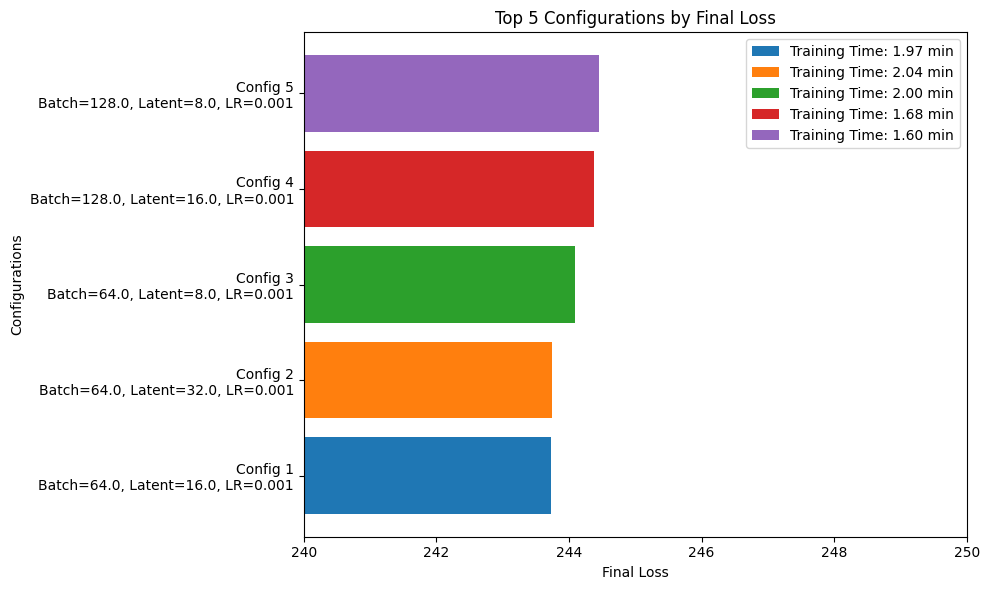

In [ ]:
import pandas as pd

# Convertir les résultats en DataFrame pour faciliter l'analyse
results_df = pd.DataFrame(results)

# Trier les résultats par 'final_loss'
results_df = results_df.sort_values(by='final_loss').reset_index(drop=True)

# Afficher les top 5 configurations
top_5 = results_df.head(5)
print("\nTop 5 Configurations:")
print(top_5)

# Visualiser les top 5 configurations
plt.figure(figsize=(10, 6))
for i, row in top_5.iterrows():
    plt.barh(
        f"Config {i+1}\nBatch={row['batch_size']}, Latent={row['latent_dim']}, LR={row['learning_rate']}",
        row['final_loss'],
        label=f"Training Time: {row['training_time']:.2f} min"
    )

plt.xlabel('Final Loss')
plt.ylabel('Configurations')
plt.title('Top 5 Configurations by Final Loss')
plt.legend(loc='upper right')
plt.xlim(240,250)
plt.tight_layout()
plt.show()



<div style="background-color: #f7f7f7; border: 1px solid #000; padding: 15px; border-radius: 25px; text-align: center; font-size: 18px; font-weight: bold;">
      <b>Entrainement du modèle avec les meilleurs hyperparamètres</b>
</div>

In [ ]:
latent_dim = 32
num_classes = 10
num_features = 28 * 28
# Hyperparameters

num_epochs = 30
learning_rate = 1e-3
beta = 1

# Initialisation du modèle et de l'optimiseur
cvae = ConditionalVariationalAutoencoder(num_features, latent_dim, num_classes)
cvae.to(device)
optimizer = torch.optim.Adam(cvae.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [ ]:
# Initialiser les listes pour enregistrer les pertes
train_loss_values = []
val_loss_values = []
kl_divergence_losses = []

# Initialisation pour le suivi des temps
start_time = time.time()

for epoch in range(1, num_epochs + 1):
    cvae.train()
    running_loss = 0.0
    running_kl_divergence_loss = 0.0

    for batch_idx, (features, targets) in enumerate(train_loader):
        features = features.to(device)
        targets = targets.to(device)

        ### FORWARD PASS
        z_mean, z_log_var, encoded, decoded = cvae(features, targets)

        ### Compute loss
        loss, recon_loss, kl_loss = loss_function(decoded, features, z_mean, z_log_var)

        ### BACKWARD AND OPTIMIZATION
        optimizer.zero_grad()  # Remet à zéro les gradients
        loss.backward()  # Backpropagation
        optimizer.step()  # Mise à jour des paramètres

        # Mise à jour des pertes cumulées
        running_loss += loss.item()
        running_kl_divergence_loss += kl_loss.item()

    # Appliquer le scheduler
    scheduler.step()

    # Calcul des pertes moyennes pour cette époque
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_kl_loss = running_kl_divergence_loss / len(train_loader.dataset)

    # Enregistrer les pertes
    train_loss_values.append(epoch_loss)
    kl_divergence_losses.append(epoch_kl_loss)

    print(f'Epoch {epoch}, Training Loss: {epoch_loss:.4f}, KL Loss: {epoch_kl_loss:.4f}')
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

    # Validation à la fin de chaque époque
    cvae.eval()
    val_loss = 0.0
    z_means, labels, z_log_vars = [], [], []
    with torch.no_grad():
        for features, targets in test_loader:
            features, targets = features.to(device), targets.to(device)
            z_mean, z_log_var, encoded, decoded = cvae(features, targets)
            loss = loss_function(decoded, features, z_mean, z_log_var)[0]
            z_means.append(z_mean.cpu().numpy())
            labels.append(targets.cpu().numpy())
            z_log_vars.append(z_log_var.cpu().numpy())
            val_loss += loss.item()

    val_loss /= len(test_loader.dataset)
    val_loss_values.append(val_loss)
    z_means = np.concatenate(z_means, axis=0)
    z_log_vars = np.concatenate(z_log_vars, axis=0)
    labels = np.concatenate(labels, axis=0)

    print(f'Validation Loss: {val_loss:.4f}')

# Affichage du temps total d'entraînement
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))




Epoch 1, Training Loss: 338.6355, KL Loss: 7.6009
Time elapsed: 0.13 min
Validation Loss: 275.3380
Epoch 2, Training Loss: 263.9432, KL Loss: 8.9329
Time elapsed: 0.29 min
Validation Loss: 260.8830
Epoch 3, Training Loss: 256.0018, KL Loss: 9.4729
Time elapsed: 0.45 min
Validation Loss: 256.4725
Epoch 4, Training Loss: 252.6962, KL Loss: 9.6112
Time elapsed: 0.59 min
Validation Loss: 253.2792
Epoch 5, Training Loss: 250.8779, KL Loss: 9.7333
Time elapsed: 0.75 min
Validation Loss: 252.5265
Epoch 6, Training Loss: 249.3775, KL Loss: 9.8256
Time elapsed: 0.90 min
Validation Loss: 251.2227
Epoch 7, Training Loss: 248.3612, KL Loss: 9.9142
Time elapsed: 1.05 min
Validation Loss: 249.4911
Epoch 8, Training Loss: 247.6006, KL Loss: 9.9719
Time elapsed: 1.20 min
Validation Loss: 249.0802
Epoch 9, Training Loss: 247.0462, KL Loss: 10.0066
Time elapsed: 1.35 min
Validation Loss: 248.9327
Epoch 10, Training Loss: 246.5313, KL Loss: 10.0896
Time elapsed: 1.50 min
Validation Loss: 247.8232
Epoch 1


<div style="background-color: #f7f7f7; border: 1px solid #000; padding: 15px; border-radius: 25px; text-align: center; font-size: 18px; font-weight: bold;">
      <b>Visualisations</b>
</div>

#### Les valeurs de loss et distribution d'espace latent

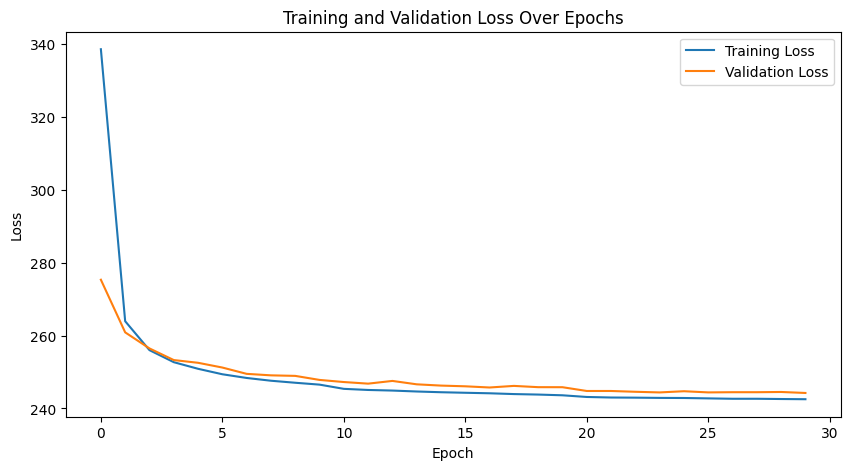

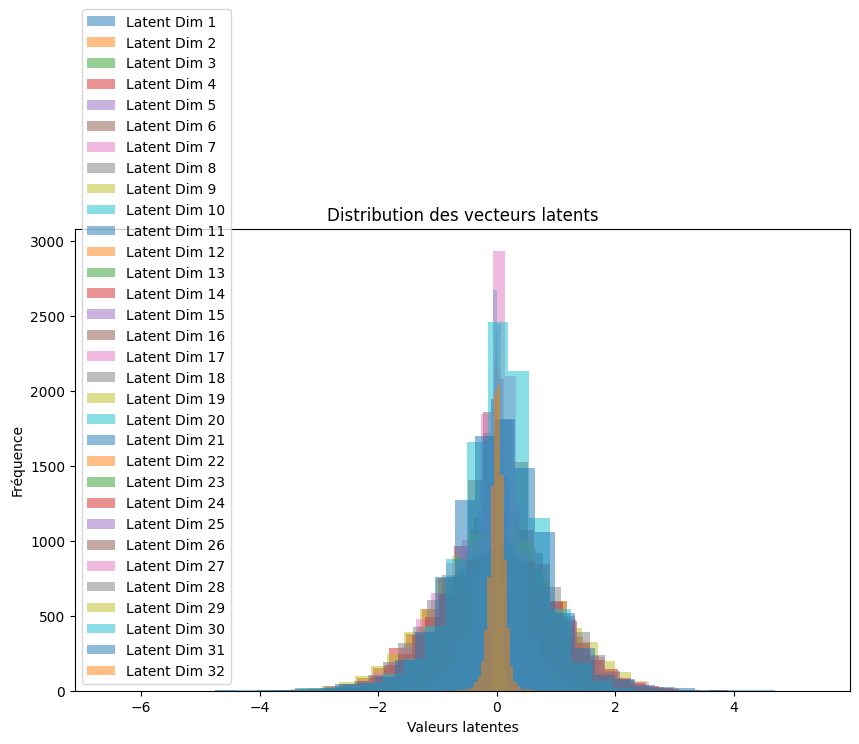

In [15]:


# Visualiser la perte d'entraînement et de validation
plt.figure(figsize=(10, 5))
plt.plot(train_loss_values, label='Training Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()


# Visualiser les distributions
plt.figure(figsize=(10, 6))
for i in range(z_means.shape[1]):  # Pour chaque dimension latente
    plt.hist(z_means[:, i], bins=30, alpha=0.5, label=f"Latent Dim {i+1}")
plt.title("Distribution des vecteurs latents")
plt.xlabel("Valeurs latentes")
plt.ylabel("Fréquence")
plt.legend()
plt.show()


#### Comparaison entre les vraies images et celles prédites réconstruites par le décodeur

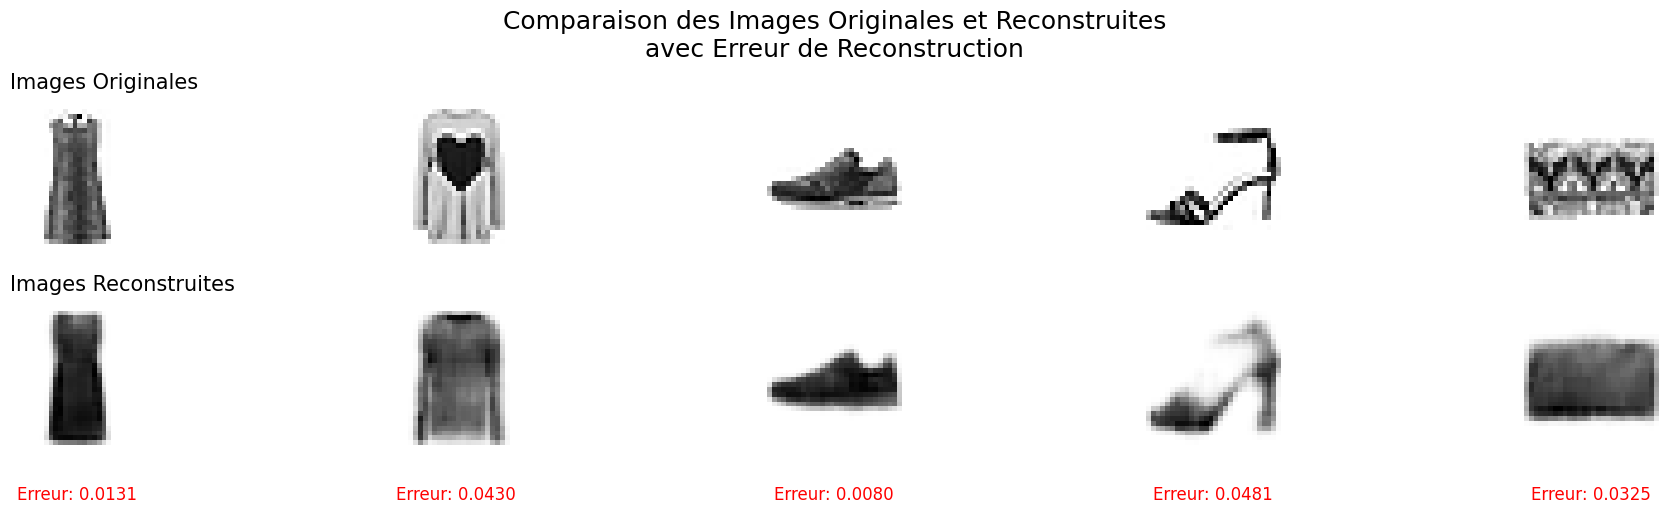

In [19]:

n_images = 5
image_width = 28

fig, axes = plt.subplots(nrows=2, ncols=n_images,
                         sharex=True, sharey=True, figsize=(20, 5))


orig_images = features[:n_images]
decoded_images = decoded[:n_images, 0]

def reconstruction_error(original, reconstructed):
    return torch.mean((original - reconstructed) ** 2).item()


fig.suptitle("Comparaison des Images Originales et Reconstruites\navec Erreur de Reconstruction", fontsize=18, y=1.05)


for i in range(n_images):

    axes[0, i].imshow(orig_images[i].detach().cpu().reshape((image_width, image_width)), cmap='binary')
    axes[0, i].axis('off')


    axes[1, i].imshow(decoded_images[i].detach().cpu().reshape((image_width, image_width)), cmap='binary')
    axes[1, i].axis('off')


    if i == 0:
        axes[1, i].set_title("Images Reconstruites", fontsize=15, loc='left', pad=15)


    axes[1, i].text(0.5, -0.4, f"Erreur: {reconstruction_error(orig_images[i], decoded_images[i]):.4f}",
                    fontsize=12, color='red', ha='center', transform=axes[1, i].transAxes)


axes[0, 0].set_title('Images Originales', fontsize=15, loc='left', pad=15)

plt.tight_layout()
plt.subplots_adjust(top=0.85, hspace=0.5)  # Décale pour laisser de l'espace
plt.show()




<div style="background-color: #e7f3fe; border: 1px solid #2196F3; padding: 15px; border-radius: 5px; box-shadow: 2px 2px 5px grey; text-align: center;">
    <b>  Génération de nouvelles images avec le CVAE</b>
</div>


Generated Images for Class: 0


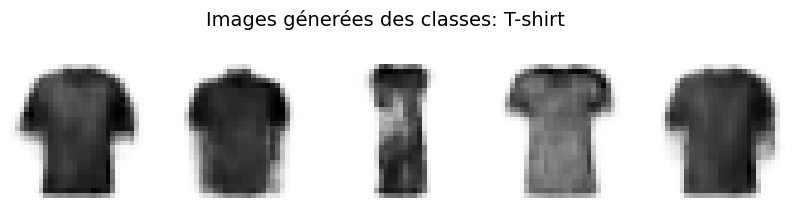

Generated Images for Class: 1


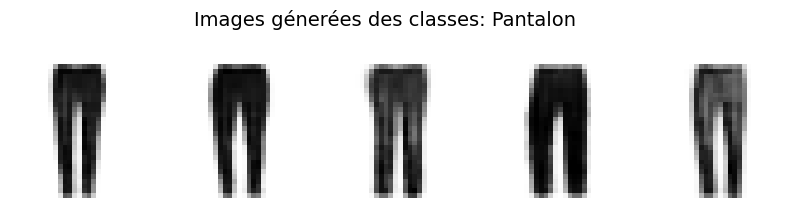

Generated Images for Class: 2


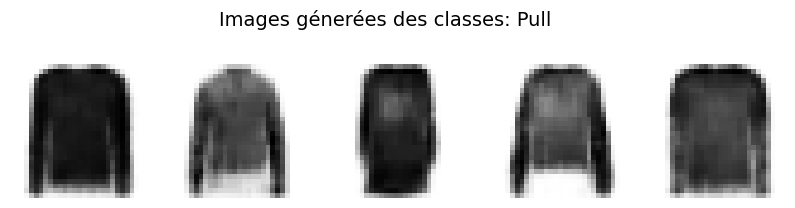

Generated Images for Class: 3


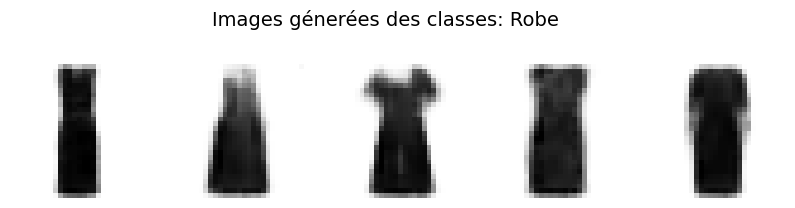

Generated Images for Class: 4


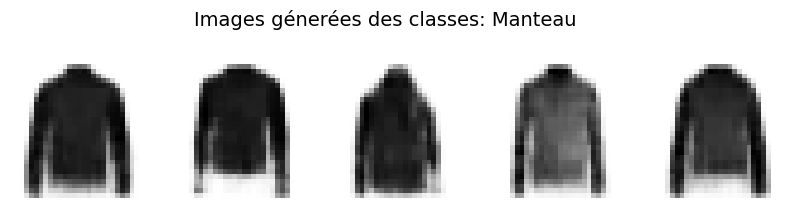

Generated Images for Class: 5


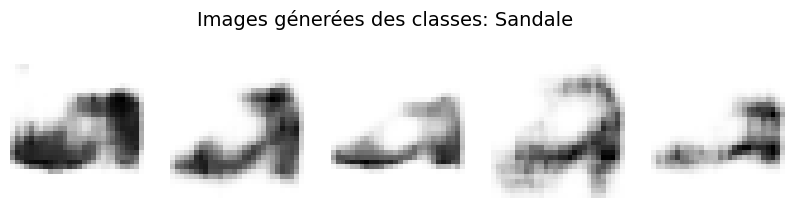

Generated Images for Class: 6


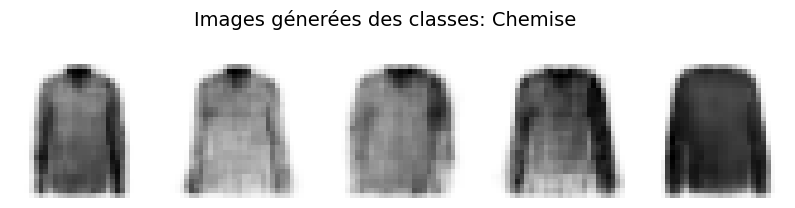

Generated Images for Class: 7


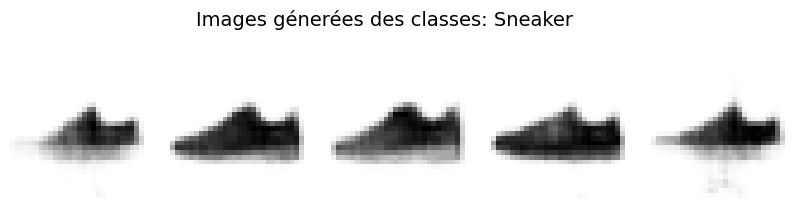

Generated Images for Class: 8


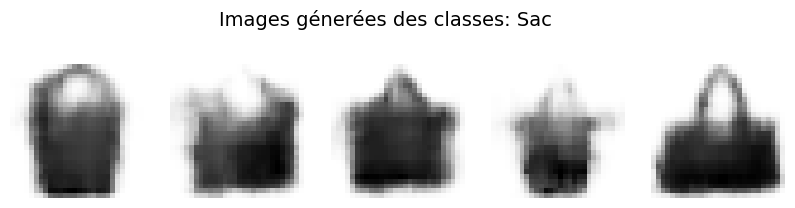

Generated Images for Class: 9


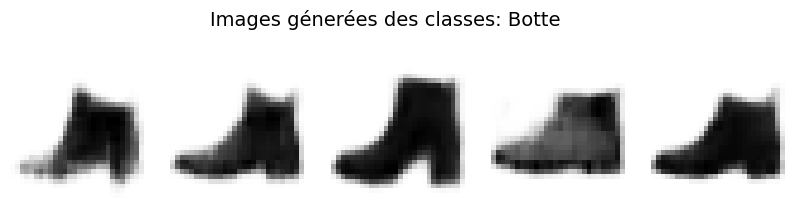

In [17]:
import matplotlib.pyplot as plt
import torch

n_images = 5
image_width = 28
n_classes = 10


# Supposons que vous travaillez avec 10 classes (Fashion-MNIST)
class_labels = ['T-shirt', 'Pantalon', 'Pull', 'Robe', 'Manteau',
                'Sandale', 'Chemise', 'Sneaker', 'Sac', 'Botte']


# Affichage pour chaque classe
for i in range(n_classes):
    ##########################
    ### RANDOM SAMPLE
    ##########################
    labels = torch.tensor([i] * n_images).to(device)  # Labels de la classe i
    rand_features = torch.randn(n_images, latent_dim).to(device)  # Vecteurs latents aléatoires
    decoded_images = cvae.decoder_step(rand_features, labels)  # Images générées

    ##########################
    ### VISUALIZATION
    ##########################
    fig, axes = plt.subplots(nrows=1, ncols=n_images, sharex=True, sharey=True, figsize=(10, 2.5))

    print(f'Generated Images for Class: {i}')  # Affiche le label de la classe

    for j in range(n_images):
        # Affiche les images générées
        curr_img = decoded_images[j].detach().cpu().reshape((image_width, image_width))
        axes[j].imshow(curr_img, cmap='binary')  # Affiche l'image en niveaux de gris
        axes[j].axis('off')  # Masque les axes

    plt.suptitle(f"Images génerées des classes: {class_labels[i]}", fontsize=14)
    plt.show()


<div style="background-color: #e7f3fe; border: 1px solid #2196F3; padding: 15px; border-radius: 5px; box-shadow: 2px 2px 5px grey; text-align: center;">
    <b>  Conclusions et bibliographies</b>
</div>

#### **Conclusions**
Le CVAE est un modèle génératif puissant, capable de générer des données réalistes tout en conditionnant le processus de génération sur des variables externes. Cette flexibilité en fait un outil précieux pour des tâches de génération d'images conditionnelles, de complétion d'images, et plus largement dans des tâches de prédiction structurée.

---

#### **Bibliographies**

1. **Introduction au CVAE**  
   [Exploration des Conditional Variational Autoencoders (CVAE)](https://ijdykeman.github.io/ml/2016/12/21/cvae.html)

2. **Travaux de recherche académique**  
   [Inria : Étude approfondie des Auto-encodeurs Variationnels Conditionnels](https://inria.hal.science/hal-02175776/document)

3. **Tutoriels pratiques avec PyTorch**  
   - [Tutoriel pratique sur les CVAE avec PyTorch](https://github.com/debtanu177/CVAE_MNIST)
   - [Implémentation pratique des autoencodeurs en PyTorch](https://github.com/lharries/PyTorch-Autoencoders/blob/master/autoencoders.ipynb)
   - [Comprendre les Auto-encodeurs Variationnels (VAE)](https://ichi.pro/fr/comprendre-les-auto-encodeurs-variationnels-vae-271601124876147)

4. **Articles explicatifs**  
   [Implémentation des Conditional Variational Autoencoders (CVAE) depuis zéro](https://medium.com/@sofeikov/implementing-conditional-variational-auto-encoders-cvae-from-scratch-29fcbb8cb08f)

---
